In [1]:
# Celda: instalar dependencias (ejecutar sólo si es necesario)
# En Kaggle algunos paquetes pueden no estar permitidos; en Colab suele funcionar mejor.
!pip install vizdoom==1.2.4 gymnasium pyvirtualdisplay imageio imageio-ffmpeg \
        opencv-python-headless torch torchvision --quiet

# Para mostrar video en entornos sin display
from pyvirtualdisplay import Display
Display(visible=0, size=(640,480)).start()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 69.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Imports principales
import gymnasium as gnm
import numpy as np, random, collections, time, cv2, imageio, torch
import torch.nn as nn, torch.nn.functional as F
from vizdoom import gymnasium_wrapper  # registra los entornos VizDoom
import vizdoom as vzd
import matplotlib.pyplot as plt
from IPython.display import Video, display

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
import cv2
import numpy as np
import gymnasium as gnm
from gymnasium import ObservationWrapper
class GrayResize(gnm.ObservationWrapper):
    def __init__(self, env, shape=(84, 84)):
        super().__init__(env)
        self.shape = shape
        # gris → (84, 84)
        self.observation_space = gnm.spaces.Box(0.0, 1.0, shape, dtype=np.float32)

    def preprocess(self, screen_buffer):
        # Si llega algo inválido → frame negro
        if screen_buffer is None:
            return np.zeros(self.shape, dtype=np.float32)

        try:
            # Convertir a array contiguo y uint8
            img = np.ascontiguousarray(screen_buffer).astype(np.uint8)

            # --- Normalizar ejes ---
            # Caso (C,H,W)
            if img.ndim == 3 and img.shape[0] in [1,3,4]:
                img = np.transpose(img, (1, 2, 0))

            # Ahora debería ser (H,W,C) o (H,W)
            
            # --- Convertir a gris ---
            if img.ndim == 3 and img.shape[2] >= 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Si aún no es 2D, convertirlo
            if img.ndim != 2:
                img = np.zeros(self.shape, dtype=np.float32)

            # --- Redimensionar ---
            img = cv2.resize(img, self.shape, interpolation=cv2.INTER_AREA)

            # Normalizar
            return (img.astype(np.float32) / 255.0)

        except Exception as e:
            # Fallback duro por si cvtColor vuelve a fallar
            return np.zeros(self.shape, dtype=np.float32)

    def observation(self, obs):
        # Gymnasium a veces devuelve dict
        if isinstance(obs, dict):
            if "screen" in obs:
                return self.preprocess(obs["screen"])
            # si no existe screen, producir frame negro
            return np.zeros(self.shape, dtype=np.float32)
        
        # Si es directamente una imagen
        return self.preprocess(obs)


# ───────────────────────────────────────────────────────────────
# RewardShaper 
# ───────────────────────────────────────────────────────────────


# 1. EL REWARD SHAPER (CON AYUDA DE APUNTADO INCLUIDA)
class RewardShaper(gnm.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.game = self.env.unwrapped.game
        self.screen_width = self.game.get_screen_width()
        self.center_x = self.screen_width / 2
        
        self.damage_prev = 0
        self.health_prev = 0
        self.pos_prev = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.damage_prev = self.game.get_game_variable(vzd.GameVariable.DAMAGECOUNT)
        self.health_prev = self.game.get_game_variable(vzd.GameVariable.HEALTH)
        
        x = self.game.get_game_variable(vzd.GameVariable.POSITION_X)
        y = self.game.get_game_variable(vzd.GameVariable.POSITION_Y)
        self.pos_prev = (x, y)
        return obs, info

    def step(self, action):
        obs, base_r, done, truncated, info = self.env.step(action)
        
        state = self.game.get_state()
        dmg = self.game.get_game_variable(vzd.GameVariable.DAMAGECOUNT)
        hp = self.game.get_game_variable(vzd.GameVariable.HEALTH)
        x = self.game.get_game_variable(vzd.GameVariable.POSITION_X)
        y = self.game.get_game_variable(vzd.GameVariable.POSITION_Y)
        
        if self.pos_prev is None: self.pos_prev = (x, y)

        dmg_delta = dmg - self.damage_prev
        hp_delta = hp - self.health_prev
        dist = np.sqrt((x - self.pos_prev[0])**2 + (y - self.pos_prev[1])**2)
        
        reward = 0.0

        # --- A. AYUDA DE APUNTADO (TRAMPA VISUAL) ---
        # Si el juego nos dice que hay un enemigo en el centro -> PREMIO
        if state is not None:
            labels = state.labels
            # Filtramos enemigos
            enemies = [l for l in labels if l.object_name in ["Cacodemon", "Demon", "HellKnight", "Imp", "Zombieman", "ShotgunGuy"]]
            
            if len(enemies) > 0:
                # Buscamos al más centrado
                closest = min(enemies, key=lambda l: abs((l.x + l.width/2) - self.center_x))
                enemy_center = closest.x + (closest.width / 2)
                diff = abs(enemy_center - self.center_x)
                
                # Si está centrado (margen 40px)
                if diff < 40:
                    reward += 0.2
                    # Si dispara teniéndolo en la mira -> PREMIO EXTRA
                    if action == 2: # ATTACK
                        reward += 0.5 

        # --- B. INCENTIVO DE MOVIMIENTO ---
        # Si se mueve, bien. Si se queda quieto y le pegan, mal.
        if dist > 1.5:
            reward += 0.02
        
        if hp_delta < 0 and dist < 1.0:
            reward -= 2.0 # Castigo por recibir daño estando quieto

        # --- C. PREMIO POR MATAR ---
        if dmg_delta > 0:
            reward += dmg_delta * 1.0
            
        # Actualizar
        self.damage_prev = dmg
        self.health_prev = hp
        self.pos_prev = (x, y)
        
        return obs, reward, done, truncated, info

In [4]:
import os
import vizdoom as vzd
import gymnasium as gnm
from gymnasium import spaces

# Definimos el wrapper manual VizDoomGym (Por si no lo tenías cargado)
class VizDoomGym(gnm.Env):
    def __init__(self, game, frame_skip=4):
        super().__init__()
        self.game = game
        self.frame_skip = frame_skip
        self.action_space = gnm.spaces.Discrete(game.get_available_buttons_size())
        h, w = game.get_screen_height(), game.get_screen_width()
        self.observation_space = gnm.spaces.Box(0, 255, (h, w, 3), dtype=np.uint8)
    
    def step(self, action_idx):
        actions = [0] * self.action_space.n
        actions[action_idx] = 1
        reward = self.game.make_action(actions, self.frame_skip)
        done = self.game.is_episode_finished()
        state = self.game.get_state()
        if state is not None:
            screen = state.screen_buffer
            if screen.shape[0] == 3: screen = np.transpose(screen, (1, 2, 0))
        else:
            screen = np.zeros(self.observation_space.shape, dtype=np.uint8)
        return screen, reward, done, False, {}
    
    def reset(self, seed=None, options=None):
        if seed is not None: self.game.set_seed(seed)
        self.game.new_episode()
        state = self.game.get_state()
        if state is not None:
            screen = state.screen_buffer
            if screen.shape[0] == 3: screen = np.transpose(screen, (1, 2, 0))
        else:
            screen = np.zeros(self.observation_space.shape, dtype=np.uint8)
        return screen, {}
    
    def render(self):
        state = self.game.get_state()
        if state and state.screen_buffer is not None:
            scr = state.screen_buffer
            if scr.ndim==3 and scr.shape[0] in [1,3]: return np.transpose(scr, (1,2,0))
            return scr
        return None
    
    def close(self): self.game.close()


def make_env(seed=None, scenario="defend_the_line.cfg", frame_skip=4):
    game = vzd.DoomGame()
    scenario_path = os.path.join(vzd.scenarios_path, scenario)
    game.load_config(scenario_path)
    
    # IMPORTANTE: Activamos Labels para que funcione la ayuda de apuntado
    game.set_labels_buffer_enabled(True) 
    game.set_doom_skill(3) 
    
    game.clear_available_buttons()
    game.add_available_button(vzd.Button.MOVE_LEFT)
    game.add_available_button(vzd.Button.MOVE_RIGHT)
    game.add_available_button(vzd.Button.ATTACK)
    game.add_available_button(vzd.Button.TURN_LEFT)
    game.add_available_button(vzd.Button.TURN_RIGHT)
    
    # Variables
    game.add_available_game_variable(vzd.GameVariable.AMMO2)
    game.add_available_game_variable(vzd.GameVariable.POSITION_X)
    game.add_available_game_variable(vzd.GameVariable.POSITION_Y)
    game.add_available_game_variable(vzd.GameVariable.HEALTH)
    game.add_available_game_variable(vzd.GameVariable.KILLCOUNT)
    game.add_available_game_variable(vzd.GameVariable.DAMAGECOUNT)
    
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
    game.set_window_visible(False)
    
    if seed is not None:
        game.set_seed(seed)
        
    game.init()
    
    # Wrapper manual VizDoomGym (asegurate de tener la clase definida arriba)
    env = VizDoomGym(game, frame_skip=frame_skip)
    
    # Aplicamos wrappers
    env = GrayResize(env)
    env = RewardShaper(env) # <--- Este es el nuevo con ayuda de apuntado
    env = gnm.wrappers.FrameStack(env, 4)
    
    return env

In [ ]:
class AimingTeacher(gnm.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.game = self.env.unwrapped.game
        self.screen_width = self.game.get_screen_width()
        self.center_x = self.screen_width / 2

    def step(self, action):
        # Ejecutamos la acción
        obs, base_r, done, truncated, info = self.env.step(action)
        
        # Obtenemos la "verdad absoluta" del juego
        state = self.game.get_state()
        reward = 0.0
        
        if state is not None:
            labels = state.labels
            
            # Filtramos solo enemigos (Monstruos)
            enemies = [l for l in labels if l.object_name in ["Cacodemon", "Demon", "HellKnight", "Imp", "Zombieman", "ShotgunGuy"]]
            
            if len(enemies) > 0:
                # Encontrar el enemigo más cercano (el que tiene mayor área o menor distancia)
                # Aquí simplificamos: tomamos el primero visible
                target = enemies[0]
                
                # Calcular dónde está el enemigo respecto al centro
                enemy_x = target.x + (target.width / 2)
                diff = enemy_x - self.center_x
                
                # --- LA CLASE MAESTRA ---
                
                # 1. Si el enemigo está Centrado (con un margen de error de 30px)
                if abs(diff) < 30:
                    reward += 1.0  # ¡BIEN! LO TIENES EN LA MIRA
                    
                    # Bonus extra si además está disparando (Acción 2 es ATTACK)
                    # Nota: action suele ser un entero en Gym wrapper
                    if action == 2: 
                        reward += 0.5
                
                # 2. Guía de corrección (Shaping)
                # Si el enemigo está a la derecha (diff > 0) y giramos derecha (Action 4) -> Bien
                # Si el enemigo está a la izquierda (diff < 0) y giramos izquierda (Action 3) -> Bien
                
                elif diff > 0 and action == 4: # Turn Right
                    reward += 0.1
                elif diff < 0 and action == 3: # Turn Left
                    reward += 0.1
                else:
                    # Si el enemigo está visible y NO estamos girando hacia él -> Castigo
                    reward -= 0.1
            else:
                # Si no hay enemigos visibles, incentivar girar para buscarlos
                if action in [3, 4]: # Turn Left/Right
                    reward += 0.05
                    
        return obs, reward, done, truncated, info

In [5]:
class ReplayBuffer:
    def __init__(self, cap, obs_shape):
        self.cap = cap
        self.ptr = 0; self.full = False
        self.s  = np.empty((cap, *obs_shape), np.uint8)
        self.a  = np.empty((cap,),            np.int64)
        self.r  = np.empty((cap,),            np.float32)
        self.s2 = np.empty((cap, *obs_shape), np.uint8)
        self.d  = np.empty((cap,),            np.bool_)

    def add(self, s,a,r,s2,d):
        self.s[self.ptr], self.a[self.ptr], self.r[self.ptr] = s, a, r
        self.s2[self.ptr], self.d[self.ptr] = s2, d
        self.ptr = (self.ptr + 1) % self.cap
        self.full |= self.ptr == 0

    def sample(self, batch):
        idx = np.random.randint(0, self.cap if self.full else self.ptr, batch)
        to_t = lambda x, dtype=None: torch.as_tensor(x, device=device, dtype=dtype)
        return (to_t(self.s[idx], dtype=torch.float32),
                to_t(self.a[idx], dtype=torch.long),
                to_t(self.r[idx], dtype=torch.float32),
                to_t(self.s2[idx], dtype=torch.float32),
                to_t(self.d[idx], dtype=torch.bool))


In [6]:
import torch
import torch.nn as nn
import numpy as np
import random
import time

# Configuración de Semilla
SEED = 123
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

class DuelingDoomDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DuelingDoomDQN, self).__init__()
        
        # Entrada (4, 84, 84)
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.feature_size = 3136 # 7x7x64 para entrada de 84x84
        
        # Stream de VALOR (Seguridad)
        self.value_stream = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
        # Stream de VENTAJA (Acción)
        self.advantage_stream = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        if x.dtype == torch.uint8:
            x = x.float() / 255.0
        features = self.conv(x)
        features = features.view(features.size(0), -1)
        val = self.value_stream(features)
        adv = self.advantage_stream(features)
        return val + (adv - adv.mean(dim=1, keepdim=True))

In [7]:
# convierte obs (84,84,4) o (4,84,84) a (4,84,84) (uint8)
def to_chw(obs):
    # --- Caso obs None ---
    if obs is None:
        return None

    arr = np.array(obs, copy=False).squeeze()

    # --- Caso arr vacío ---
    if arr.size == 0:
        return None

    # Asegurar que es numérico y convertible
    if not isinstance(arr, np.ndarray):
        return None

    # (H, W, C) → (C, H, W)
    if arr.ndim == 3 and arr.shape[-1] in (1, 3, 4):
        arr = np.transpose(arr, (2, 0, 1))

    # (H, W) → (1, H, W)
    if arr.ndim == 2:
        arr = arr[None, :, :]

    # Verificación final de dimensiones
    if arr.ndim != 3:
        return None

    return arr.astype(np.uint8)
def record_checkpoint(net, step, max_frames=1_000, fps=30, filename_prefix="dqn_step"):
    tag = f"{filename_prefix}_{step:,}".replace(",", "_")
    torch.save(net.state_dict(), f"{tag}.pth")

    env_eval = make_env()
    frames, ep_R = [], 0

    # --- Reset seguro ---
    s, _ = env_eval.reset()
    s = to_chw(s)

    if s is None:
        print(" Error: el reset del entorno devolvió una observación inválida.")
        return

    done = False

    with torch.no_grad():
        while not done and len(frames) < max_frames:

            # --- Acción ---
            a = net(torch.tensor(s[None], device=device)).argmax(1).item()

            # --- Paso del entorno ---
            nxt, r, done, term, _ = env_eval.step(a)
            s = to_chw(nxt)

            if s is None:
                print("⚠️ Frame ignorado: observación inválida en step()")
                continue

            ep_R += r

            # --- Render seguro ---
            frame = env_eval.render()

            if frame is None:
                print(" Ignorando frame: render() devolvió None")
                continue

            # Asegurar formato uint8 tipo imagen
            frame = np.array(frame, dtype=np.uint8)

            if frame.ndim == 2:              # grayscale → rgb
                frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

            elif frame.shape[-1] == 4:       # RGBA → RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)

            frames.append(frame)

    env_eval.close()

    # --- Guardado del video ---
    if len(frames) == 0:
        print(" No se pudo grabar el episodio: todos los frames fueron inválidos.")
        return

    imageio.mimsave(f"{tag}.mp4", frames, fps=fps)
    print(f" Guardado {tag}.pth  🎞️ {tag}.mp4  |  Reward={ep_R:.1f}")


In [8]:
# --- HIPERPARÁMETROS DE REACCIÓN RÁPIDA ---

LR               = 0.0002     # (2.5e-4) Agresivo pero estable
GAMMA            = 0.95       # Importante para prever el daño futuro
BATCH_SIZE       = 54         # CRÍTICO: Lote pequeño para aprender traumas rápido
BUFFER_SIZE      = 50_000      # Memoria fresca
TARGET_UPDATE      = 1_000       # Actualizar red objetivo frecuentemente

EPS_START        = 1.00
EPS_END          = 0.05
EPS_DECAY        = 30_000      # Exploración rápida (en 30k steps ya debe saber huir)

MAX_STEPS        = 200_000     
LOG_EVERY        = 500
CHECKPOINT_EVERY = 10_000

In [9]:
import random
import numpy as np
import torch
import time

# Semilla nueva para romper la maldición
SEED = 777 
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# 1. Entorno (Skill 3: Hurt me plenty - Balanceado para que no muera instántaneo)
env = make_env(SEED)
env.game.set_doom_skill(3) 
n_actions = env.action_space.n
input_shape = (4, 84, 84)

# 2. Red Dueling
q_net = DuelingDoomDQN(input_shape, n_actions).to(device)
tgt_net = DuelingDoomDQN(input_shape, n_actions).to(device)
tgt_net.load_state_dict(q_net.state_dict())

opt = torch.optim.Adam(q_net.parameters(), lr=LR)
buf = ReplayBuffer(BUFFER_SIZE, input_shape)

rewards, eps = [], EPS_START

# Reset inicial
state, _ = env.reset(seed=SEED)
while state is None or (isinstance(state, np.ndarray) and state.size == 0):
    state, _ = env.reset(seed=SEED)

state = np.array(state)
if state.ndim == 3 and state.shape[-1] == 4:
    state = np.transpose(state, (2,0,1)) # HWC -> CHW
state = np.array(state, dtype=np.uint8)

print("Estrategia 'Reward Gating' Activada.")
print("Regla: Si Velocidad == 0 -> Puntos == 0.")

/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.game to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.game` for environment variables or `env.get_attr('game')` that will search the reminding wrappers.
  logger.warn(


Estrategia 'Reward Gating' Activada.
Regla: Si Velocidad == 0 -> Puntos == 0.


In [10]:
import torch.optim as optim
import torch.nn.functional as F




# Inicializar Redes Dueling
n_actions = env.action_space.n
input_shape = (4, 84, 84) # FrameStack size

q_net = DuelingDoomDQN(input_shape, n_actions).to(device)
tgt_net = DuelingDoomDQN(input_shape, n_actions).to(device)
tgt_net.load_state_dict(q_net.state_dict())
tgt_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=LR)

print("🚀 INICIANDO ENTRENAMIENTO DUELING DOUBLE DQN...")

state, _ = env.reset()
rewards_history = []
ep_reward = 0

for step in range(1, MAX_STEPS + 1):
    
    # 1. Epsilon Greedy
    eps = max(EPS_END, EPS_START - (step / EPS_DECAY))
    
    # Convertir estado a tensor
    state_tensor = torch.tensor(np.array(state), dtype=torch.uint8, device=device).unsqueeze(0)
    
    if np.random.random() < eps:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = q_net(state_tensor).argmax(1).item()
            
    # 2. Ejecutar
    next_state, reward, done, truncated, _ = env.step(action)
    
    # Guardar en Buffer
    # Asegúrate de guardar arrays numpy, no tensores, para ahorrar VRAM
    buf.add(np.array(state), action, reward, np.array(next_state), done)
    
    state = next_state
    ep_reward += reward
    
    # 3. APRENDIZAJE (DOUBLE DQN)
    if step > 2000 and (buf.ptr > BATCH_SIZE or buf.full):
        
        # Samplear
        s, a, r, s2, d = buf.sample(BATCH_SIZE)
        
        # Convertir a float para la red
        s = s.float() / 255.0
        s2 = s2.float() / 255.0
        
        # A. Calcular Q(s, a) actual
        curr_q = q_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
        
        # B. Calcular Q(s', a') usando DOUBLE DQN
        with torch.no_grad():
            # 1. Usar red ONLINE para elegir la mejor acción futura
            best_action_next = q_net(s2).argmax(1).unsqueeze(1)
            # 2. Usar red TARGET para calcular el valor de esa acción
            target_q_next = tgt_net(s2).gather(1, best_action_next).squeeze(1)
            # 3. Bellman
            expected_q = r + GAMMA * target_q_next * (~d)
            
        # C. Loss y Backprop
        loss = F.smooth_l1_loss(curr_q, expected_q)
        
        optimizer.zero_grad()
        loss.backward()
        # CLIPPING: Vital para evitar que recompensas grandes rompan la red
        torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
        optimizer.step()
        
        # Actualizar Target Network
        if step % TARGET_UPDATE == 0:
            tgt_net.load_state_dict(q_net.state_dict())
            
    # 4. Logging
    if done or truncated:
        rewards_history.append(ep_reward)
        avg_reward = np.mean(rewards_history[-20:]) if rewards_history else 0
        
        if len(rewards_history) % 5 == 0:
            print(f"Step {step} | Eps: {eps:.2f} | Ep Reward: {ep_reward:.2f} | Avg(20): {avg_reward:.2f}")
            
        ep_reward = 0
        state, _ = env.reset()
        
    if step % 10000 == 0:
        torch.save(q_net.state_dict(), f"dueling_dqn_step_{step}.pth")

env.close()

🚀 INICIANDO ENTRENAMIENTO DUELING DOUBLE DQN...
Step 3531 | Eps: 0.88 | Ep Reward: 154.50 | Avg(20): 86.34
Step 6423 | Eps: 0.79 | Ep Reward: 160.30 | Avg(20): 93.47
Step 9386 | Eps: 0.69 | Ep Reward: 54.30 | Avg(20): 99.70
Step 12549 | Eps: 0.58 | Ep Reward: 128.75 | Avg(20): 101.83
Step 15010 | Eps: 0.50 | Ep Reward: 61.15 | Avg(20): 99.62
Step 17650 | Eps: 0.41 | Ep Reward: 51.25 | Avg(20): 93.44
Step 20656 | Eps: 0.31 | Ep Reward: 134.80 | Avg(20): 85.74
Step 23022 | Eps: 0.23 | Ep Reward: 38.85 | Avg(20): 69.68
Step 25449 | Eps: 0.15 | Ep Reward: 0.35 | Avg(20): 54.40
Step 26913 | Eps: 0.10 | Ep Reward: -11.80 | Avg(20): 34.11
Step 29014 | Eps: 0.05 | Ep Reward: -12.40 | Avg(20): 13.18
Step 31256 | Eps: 0.05 | Ep Reward: -10.50 | Avg(20): 2.11
Step 33386 | Eps: 0.05 | Ep Reward: -7.35 | Avg(20): -1.92
Step 35210 | Eps: 0.05 | Ep Reward: -4.70 | Avg(20): -0.61
Step 37271 | Eps: 0.05 | Ep Reward: 37.85 | Avg(20): 2.50
Step 38871 | Eps: 0.05 | Ep Reward: -11.95 | Avg(20): 0.57
Step 4

In [11]:
# Guardar modelo manualmente
torch.save(q_net.state_dict(), "dqn_defendline_manual.pth")
# Cargar
# q_net.load_state_dict(torch.load("dqn_defendline_manual.pth", map_location=device))
# q_net.eval()


In [12]:
# Forma de entrada para la red (4 canales apilados de 84x84)
INPUT_SHAPE = (4, 84, 84) 

def play_and_record(model_path, vid="dqn_defendline_eval.mp4", episodes=3, fps=30):
    # Asegúrate de que 'make_env' carga el entorno con las variables necesarias
    env = make_env() 
    
    # --- CORRECCIÓN CLAVE ---
    # 1. Cambiamos a DuelingDoomDQN
    # 2. Pasamos la forma de entrada (input_shape)
    net = DuelingDoomDQN(INPUT_SHAPE, env.action_space.n).to(device)
    
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.eval()

    frames, ep_ret = [], []

    for _ in range(episodes):
        # El reset debe ser robusto y siempre obtener el estado inicial
        s, _ = env.reset()
        
        # El estado inicial debe convertirse a CHW (4, 84, 84)
        s = to_chw(s) 

        # Si llega None o vacío, repetir hasta que llegue correcto
        while s is None or (isinstance(s, np.ndarray) and s.size == 0):
            s, _ = env.reset()
            s = to_chw(s)

        R, done = 0, False

        while not done:
            with torch.no_grad():
                # La red espera un tensor (Batch, C, H, W)
                a = net(torch.tensor(s[None], device=device)).argmax(1).item()

            s2, r, done, _, _ = env.step(a)

            # --- render seguro ---
            frame = env.render()
            if frame is not None:
                # El render suele devolver (H, W, C). Lo almacenamos como HWC para el video.
                frame = np.array(frame)
                if frame.ndim == 3 and frame.shape[0] in [1,3]:
                    frame = np.transpose(frame, (1,2,0)) # C H W -> H W C
                frames.append(frame.astype(np.uint8))

            # --- nuevo estado (C, H, W) ---
            s = to_chw(s2)
            R += r

        ep_ret.append(R)

    env.close()
    
    # imageio.mimsave para guardar el video
    print(f"Guardando video con {len(frames)} frames...")
    imageio.mimsave(vid, frames, fps=fps)
    return vid, ep_ret

Guardando video con 1500 frames...
Recompensas de evaluación por episodio: [-9.95, -13.05, -10.899999999999999]


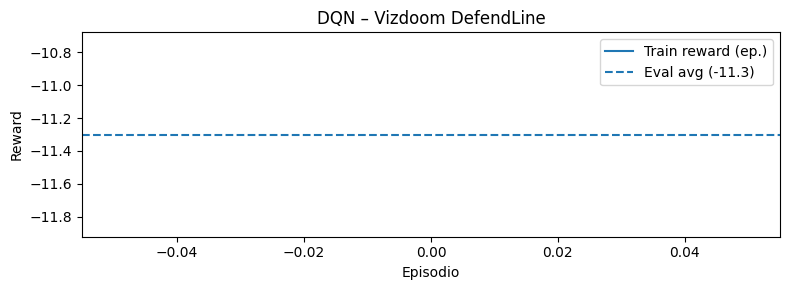

In [13]:
# Ajusta el nombre del archivo del modelo que quieras evaluar
model_file = "dqn_defendline_manual.pth"  # o dqn_defendline_final.pth o dqn_step_X.pth
vid_path, eval_R = play_and_record(model_file, vid="dqn_eval.mp4", episodes=3)
print("Recompensas de evaluación por episodio:", eval_R)

# Mostrar video embebido
display(Video(vid_path, embed=True, height=480))

# Graficar curva de reward de entrenamiento si existe la lista 'rewards'
try:
    plt.figure(figsize=(8,3))
    plt.plot(rewards, label="Train reward (ep.)")
    plt.axhline(np.mean(eval_R), ls="--", label=f"Eval avg ({np.mean(eval_R):.1f})")
    plt.xlabel("Episodio"); plt.ylabel("Reward"); plt.title("DQN – Vizdoom DefendLine")
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print("No hay variable `rewards` para graficar (quizá no entrenaste en esta sesión).", e)
